# Question 5

In [1]:
df <- read.csv('data-p2/encoded_filtered_mimic3d.csv')
x <- model.matrix(~ . - 1, data = df[, c('NumTransfers', 'NumCallouts')])
x <- scale(x)  # Standardize x to have mean 0 and variance 1
y <- df$LOSdays  # Dependent variable as a vector
y <- scale(y)

In [2]:
set.seed(0) # for replicability
t.A <- 10 # true slope
t.B <- 0 # true intercept
t.sd <- 20 # true noise

In [8]:
likehd <- function(param){
  param <- as.numeric(param)
  a = param[1:(ncol(x))]  # Coefficients
  b = param[length(param) - 1]  # Intercept
  sd = param[length(param)]  # Standard deviation

  # Predicted values
  pred = as.numeric(x %*% a) + b

  # Ensure sd is valid to avoid log(0) or Inf in the likelihood calculation
  if (sd <= 0) {
    return(-Inf)  # Invalid standard deviation, return -Inf
  }

  # Calculate log-likelihood
  singlelikelihoods = dnorm(y, mean = pred, sd = sd, log = TRUE)
  sumll = sum(singlelikelihoods)
  
  # Debug: Print log-likelihood
  print(paste("Log-likelihood:", sumll))
  
  return(sumll)
}

In [9]:
prior <- function(param, lambda = 1) {
  a = param[1:(length(param) - 2)]
  b = param[length(param) - 1]
  sd = param[length(param)]

  # Laplace prior for coefficients
  aprior = sum(dexp(abs(a), rate = lambda, log = TRUE))

  # Normal prior for intercept
  bprior = dnorm(b, mean = t.B, sd = 5, log = TRUE)

  # Ensure sd is valid to avoid returning invalid priors
  if (sd <= 0) {
    return(-Inf)  # Invalid sd, return -Inf
  }

  # Uniform prior for standard deviation
  sdprior = dunif(sd, min = 0, max = 2 * t.sd, log = TRUE)

  # Debug: Print log-prior values
  print(paste("Log-prior a:", aprior, "b:", bprior, "sd:", sdprior))

  return(aprior + bprior + sdprior)
}

In [10]:
posterior <- function(param){
return (likehd(param) + prior(param))
}


In [16]:
proposalfunction <- function(param){ 
return(rnorm(4,mean = param, sd = rep(0.01, 4)))
}

run_metropolis_MCMC <- function(startvalue, iterations){
  num_params <- length(startvalue)  # Number of parameters based on the starting value
  chain = array(dim = c(iterations + 1, num_params))  # Initialize the chain for the correct number of params
  chain[1,] = startvalue  # Set the initial value of the chain
  
  for (i in 1:iterations){
    proposal = proposalfunction(chain[i,])   # Generate a proposal using the current chain value

    # Debug: print intermediate values to ensure calculations are correct
    print("Calculating posterior for proposal:")
    print(proposal)
    post_proposal <- posterior(proposal)  # Calculate posterior for the proposal
    print(post_proposal)
    
    post_chain <- posterior(chain[i,])  # Calculate posterior for the current chain value
    print(post_chain)
    
    probab <- exp(post_proposal - post_chain)  # Metropolis acceptance criterion
    print(probab)  # Check if probab is calculated properly

    # Ensure probab is a scalar value
    probab <- min(probab, 1)  # Probability should be <= 1

    # Accept or reject the proposal based on the probability
    if (runif(1) < probab){
      chain[i + 1,] = proposal   # Accept the proposal
    } else {
      chain[i + 1,] = chain[i,]  # Reject the proposal, keep the current value
    }
  }
  
  return(chain)  # Return the entire MCMC chain
}

# Generate a starting value with 105 parameters
start_value <- runif(4)  # Random initial values for the parameters

# Run the Metropolis-Hastings MCMC with the starting value and 10,000 iterations
chain <- run_metropolis_MCMC(start_value, 10000)

[1] "Calculating posterior for proposal:"
[1] 0.8480113 0.7942009 0.9315414 0.8174564
[1] "Log-likelihood: -10632.7610501084"
[1] "Log-prior a: -1.64221213939174 b: -2.54573183273107 sd: -3.68887945411394"
[1] -10640.64
[1] "Log-likelihood: -10768.5541173901"
[1] "Log-prior a: -1.65115938242525 b: -2.54583976650813 sd: -3.68887945411394"
[1] -10776.44
[1] 9.508509e+58
[1] "Calculating posterior for proposal:"
[1] 0.8336748 0.7910921 0.9388159 0.8157926
[1] "Log-likelihood: -10613.2067487059"
[1] "Log-prior a: -1.62476691556261 b: -2.54600395146663 sd: -3.68887945411394"
[1] -10621.07
[1] "Log-likelihood: -10632.7610501084"
[1] "Log-prior a: -1.64221213939174 b: -2.54573183273107 sd: -3.68887945411394"
[1] -10640.64
[1] 316070076
[1] "Calculating posterior for proposal:"
[1] 0.8299033 0.7804096 0.9487715 0.7997120
[1] "Log-likelihood: -10876.4907670323"
[1] "Log-prior a: -1.61031293358333 b: -2.54637979462578 sd: -3.68887945411394"
[1] -10884.34
[1] "Log-likelihood: -10613.2067487059"
[

In [17]:
burnIn = 5000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))

In [18]:
print(head(chain[-(1:burnIn), 1]))  # Check the first few values of the chain after burn-in
print(summary(chain[-(1:burnIn), 1]))  # Summary statistics of the chain for parameter a

[1] -0.1959686 -0.1827572 -0.1827572 -0.1825996 -0.1825996 -0.1788537


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2381 -0.1976 -0.1854 -0.1856 -0.1733 -0.1190 


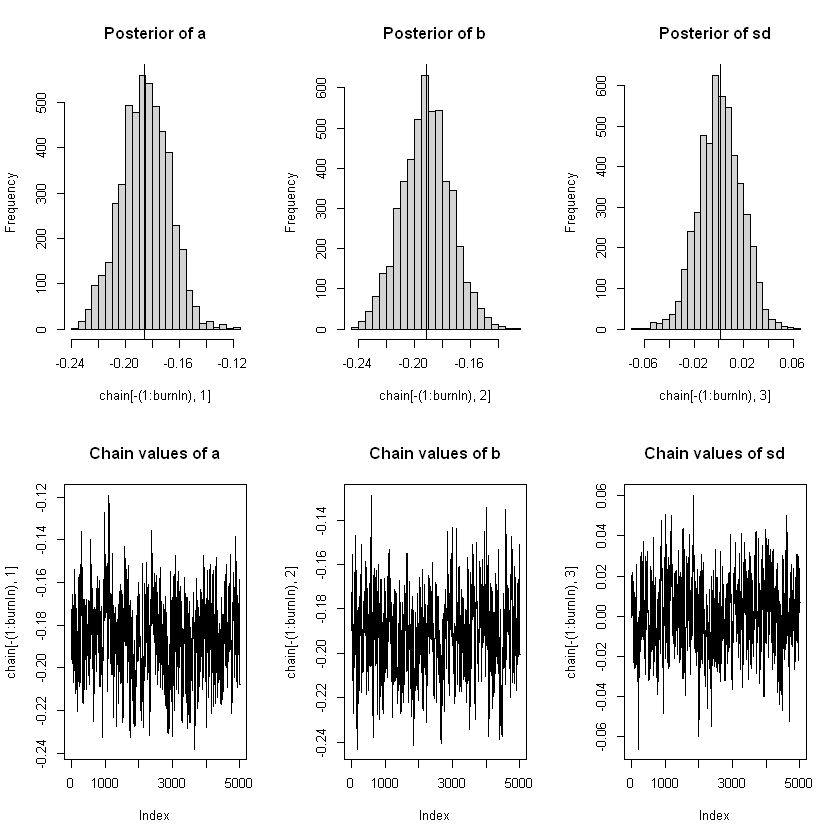

In [19]:
par(mfrow = c(2,3))
hist(chain[-(1:burnIn),1],nclass=30, main="Posterior of a")
abline(v = mean(chain[-(1:burnIn),1]))
# abline(v = t.A, col="red" )
hist(chain[-(1:burnIn),2],nclass=30, main="Posterior of b")
abline(v = mean(chain[-(1:burnIn),2]))
# abline(v = t.B, col="red" )
hist(chain[-(1:burnIn),3],nclass=30, main="Posterior of sd")
abline(v = mean(chain[-(1:burnIn),3]) )
# abline(v = t.sd, col="red" )
plot(chain[-(1:burnIn),1], type = "l", main = "Chain values of a")
# abline(h = t.A, col="red" )
plot(chain[-(1:burnIn),2], type = "l", main = "Chain values of b")
# abline(h = t.B, col="red" )
plot(chain[-(1:burnIn),3], type = "l", main = "Chain values of sd")
# abline(h = t.sd, col="red" )

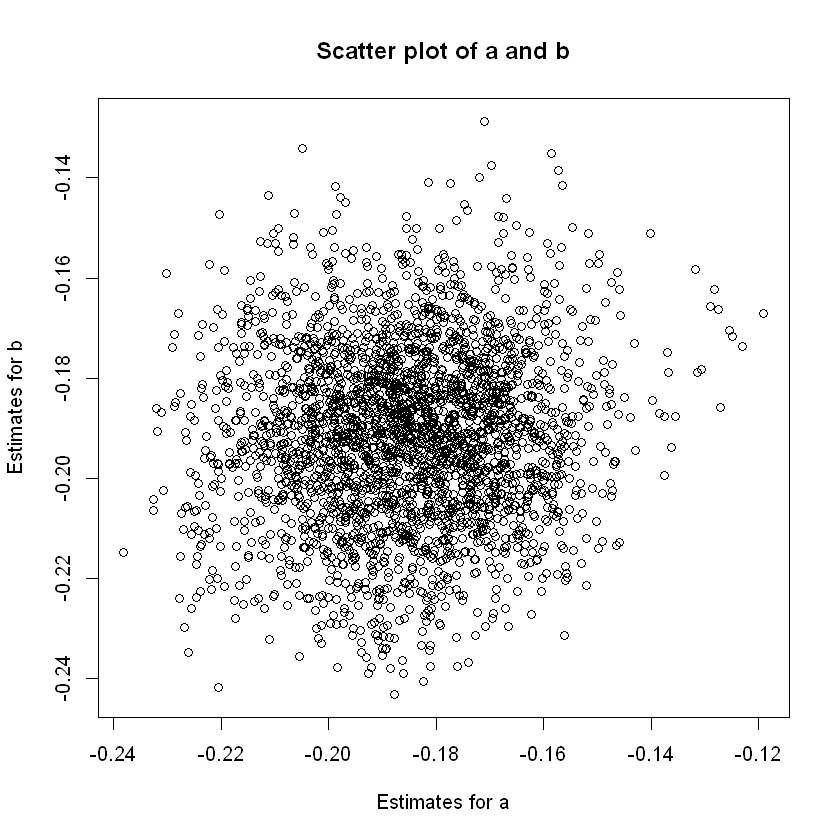

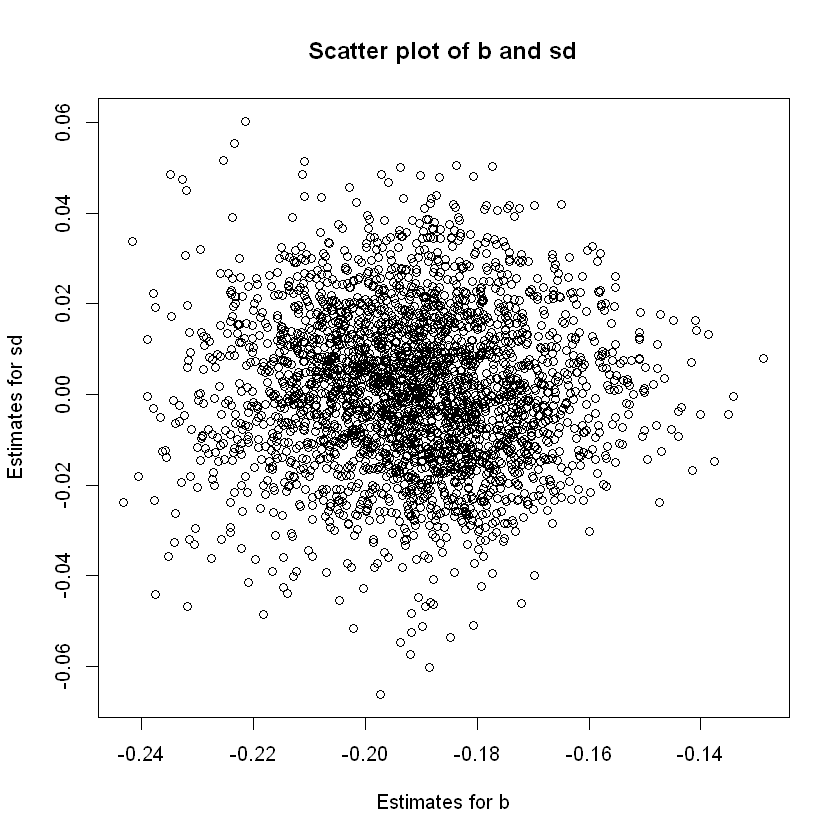

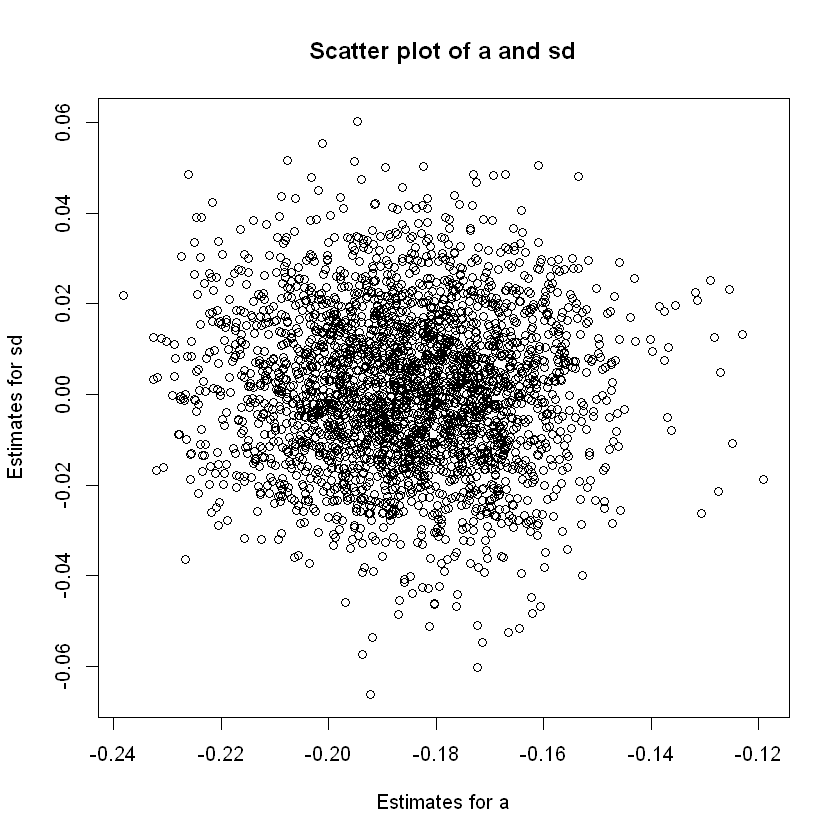

In [20]:
plot(chain[-(1:burnIn),1:2], main="Scatter plot of a and b",
xlab="Estimates for a", ylab="Estimates for b")
# abline(v = t.A, col="red" )
# abline(h = t.B, col="red" )
plot(chain[-(1:burnIn),2:3], main="Scatter plot of b and sd",
xlab="Estimates for b", ylab="Estimates for sd")
# abline(v = t.B, col="red" )
# abline(h = t.sd, col="red" )
plot(chain[-(1:burnIn),c(1,3)], main="Scatter plot of a and sd",
xlab="Estimates for a", ylab="Estimates for sd")
# abline(v = t.A, col="red" )
# abline(h = t.sd, col="red" )

In [21]:
summary(lm(y~x))


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9791 -0.4730 -0.2073  0.0860 15.6175 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -7.212e-17  1.768e-02    0.00        1    
xNumTransfers -1.834e-01  1.768e-02  -10.37   <2e-16 ***
xNumCallouts  -1.933e-01  1.768e-02  -10.93   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9645 on 2973 degrees of freedom
Multiple R-squared:  0.07033,	Adjusted R-squared:  0.06971 
F-statistic: 112.5 on 2 and 2973 DF,  p-value: < 2.2e-16
